In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(2, 51126)

In [4]:
data_loaded['Sum PrestoKNe_score_s UserPointsSlicer'].loc['ender_a1_v3.1_10yrs'], data_loaded['Sum PrestoKNe_score_s UserPointsSlicer'].loc['baseline_v3.0_10yrs']

KeyError: 'ender_a1_v3.1_10yrs'

In [5]:
#[col for col in data_loaded.columns if 'LVDwarfs' in col]
#[col for col in data_loaded.columns if 'KNePop' in col and 'Total detected' in col and 'ztfrest_simple ' in col and 'DD' in col ]
[col for col in data_loaded.columns if 'Gaps' in col and 'r band' in col]

['Mean Gaps_24hr r band HealpixSlicer',
 'Mean Gaps_3hr r band HealpixSlicer',
 'Mean Gaps_7hr r band HealpixSlicer',
 'Mean N gaps in y at 24hr in top 18k Gaps_24hr r band HealpixSlicer',
 'Mean N gaps in y at 3hr in top 18k Gaps_3hr r band HealpixSlicer',
 'Mean N gaps in y at 7hr in top 18k Gaps_7hr r band HealpixSlicer',
 'Median Gaps_24hr r band HealpixSlicer',
 'Median Gaps_3hr r band HealpixSlicer',
 'Median Gaps_7hr r band HealpixSlicer',
 'Median N gaps in y at 24hr in top 18k Gaps_24hr r band HealpixSlicer',
 'Median N gaps in y at 3hr in top 18k Gaps_3hr r band HealpixSlicer',
 'Median N gaps in y at 7hr in top 18k Gaps_7hr r band HealpixSlicer']

In [6]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'FF u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'FF g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'FF r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'FF i',
    'best18k parallax HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
             'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
             'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad'}
            #}
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
         'FF u': '',
         'FF g': '',
         'FF r': '',
         'FF i': '',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 
gaps_dict = {}
for filtername in 'ugrizy':
    for times in [3,7,24]:
        gaps_dict['Mean Gaps_%ihr %s band HealpixSlicer' % (times, filtername)] = 'gaps %s %i' % (filtername, times)
        
gaps_data = pd.DataFrame()
for key in gaps_dict:
    gaps_data[gaps_dict[key]] = data_loaded[key]

In [7]:
#data['KNe single model'] # data['KNe ZTF simple']

In [8]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
#data['KNe ZTF simple']

In [9]:
mag_data

,g,i,r,u,y,z
baseline_v3.2_10yrs,26.696522,26.280475,26.811614,25.622221,24.780784,25.566586
more_long_v3.2_10yrs,26.613533,26.240133,26.776142,25.588970,24.767825,25.538737


In [10]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

,N SN COSMOS,N SN ECDFS,N SN EDFS,N SN ELAISS1,N SN XMM_LSS,zlim COSMOS,zlim ECDFS,zlim EDFS,zlim ELAISS1,zlim XMM_LSS,Kne COSMOS,Kne ECDFS,Kne EDFS,Kne ELAISS1,Kne WFD,Kne XMM_LSS
baseline_v3.2_10yrs,567.853209,331.480163,698.794240,297.421154,311.588766,0.566437,0.588491,0.527025,0.577627,0.557767,368.0,361.0,426.0,357.0,293.0,321.0
more_long_v3.2_10yrs,574.687690,321.765649,691.274792,296.387868,316.442912,0.571715,0.587241,0.524197,0.579734,0.560123,368.0,372.0,419.0,323.0,291.0,302.0


In [11]:
gaps_data

,gaps u 3,gaps u 7,gaps u 24,gaps g 3,gaps g 7,gaps g 24,gaps r 3,gaps r 7,gaps r 24,gaps i 3,gaps i 7,gaps i 24,gaps z 3,gaps z 7,gaps z 24,gaps y 3,gaps y 7,gaps y 24
baseline_v3.2_10yrs,0.081171,0.059398,2.130439,0.422236,0.413635,2.590710,0.810905,0.537287,14.559337,1.226057,0.853937,13.040251,0.806594,0.418198,11.925169,0.671715,0.279243,8.586768
more_long_v3.2_10yrs,0.088313,0.028966,2.295116,0.448700,0.387630,2.787876,2.298817,2.013418,13.469040,2.767586,2.395830,12.658263,1.313279,1.264390,11.136710,0.570741,0.176343,7.164945


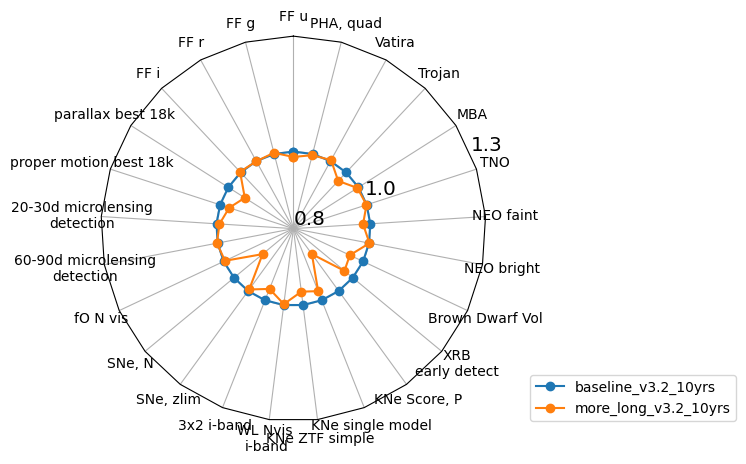

In [13]:
runs = [run for run in data.index ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.3], bbox_to_anchor=(1.65, 0))

In [ ]:
# So it looks like the g band is rarely the second on a long gap? 